# Real-world Data Wrangling

### Problem Statement
The aim of this project is to gather job listing data for Data Scientist positions in New York City
from two different sources, clean the data, combine it, and perform exploratory data analysis to
answer the research question: "Which companies are hiring the most Data Scientists in New York City?"


In [ ]:
#Install necessary libraries
!pip install pandas
!pip install matplotlib
!pip install selenium
!pip install webdriver-manager
!pip install beautifulsoup4
!pip install requests


In [17]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import requests
import time

#### Dataset 1 (fetch job listings from Indeed website) 

In [18]:
# Function to fetch job listings from Indeed using Selenium with pagination
def fetch_job_listings(url):
    options = Options()
    options.headless = True
    driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
    driver.get(url)
    driver.implicitly_wait(10)  # Wait for dynamic content to load

    all_html_content = []
    while True:
        html_content = driver.page_source
        all_html_content.append(html_content)
        
        # Find and click the "Next" button
        try:
            next_button = driver.find_element(By.CSS_SELECTOR, 'a[aria-label="Next Page"]')
            if next_button.is_enabled():
                next_button.click()
                time.sleep(3)  # Wait for the next page to load
            else:
                break
        except Exception as e:
            print("No more pages to fetch")
            break
    
    driver.quit()
    return all_html_content

# Function to parse job listings from Indeed
def parse_job_listings(html_content_list):
    jobs = []
    for content in html_content_list:
        soup = BeautifulSoup(content, 'html.parser')
        job_cards = soup.find_all('div', class_='job_seen_beacon')
        for job in job_cards:
            title = job.find('h2', class_='jobTitle').text.strip() if job.find('h2', class_='jobTitle') else 'No title'
            company = job.find('div', class_='css-1qv0295 e37uo190').text.strip() if job.find('div', class_='css-1qv0295 e37uo190') else 'No company'
            location = job.find('div', class_='css-1p0sjhy eu4oa1w0').text.strip() if job.find('div', class_='css-1p0sjhy eu4oa1w0') else 'No location'
            jobs.append({'title': title, 'company': company, 'location': location})
    return jobs

# Fetch job listings from Indeed
url_indeed = 'https://www.indeed.com/jobs?q=data+scientist&l=New+York%2C+NY&start=0'
html_content_list_indeed = fetch_job_listings(url_indeed)

# Parse job listings from Indeed
if html_content_list_indeed:
    jobs_indeed = parse_job_listings(html_content_list_indeed)

    # Create a DataFrame and save to CSV
    df_indeed = pd.DataFrame(jobs_indeed)
    df_indeed.to_csv('job_listings_indeed.csv', index=False)
    print(df_indeed.head())
else:
    print('Failed to fetch HTML content from Indeed.')



No more pages to fetch
                                   title  \
0             Data Scientist, Amazon Ads   
1      Data Scientist, Llama Scalability   
2  Data Scientist - Marketing Mix Models   
3                   Staff Data Scientist   
4                  Senior Data Scientist   

                                 company  \
0                Amazon.com Services LLC   
1                                   Meta   
2                                Verizon   
3                 Warner Bros. Discovery   
4  Metropolitan Transportation Authority   

                                       location  
0                                  New York, NY  
1                                  New York, NY  
2                   Hybrid work in New York, NY  
3             New York, NY 10001 (Chelsea area)  
4  New York, NY 10004 (Financial District area)  


#### Dataset 2 (Adzuna.com using an API) 

In [19]:
# Function to fetch job listings from Adzuna using an API
def fetch_job_listings_adzuna(app_id, api_key, location, job_title):
    url = f"https://api.adzuna.com/v1/api/jobs/us/search/1"
    params = {
        'app_id': app_id,
        'app_key': api_key,
        'results_per_page': 50,
        'what': job_title,
        'where': location
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to retrieve job listings: {response.status_code}")
        return None

# Parse job listings from Adzuna API response
def parse_job_listings_adzuna(response_json):
    jobs = []
    if response_json:
        for job in response_json['results']:
            title = job.get('title', 'No title')
            company = job.get('company', {}).get('display_name', 'No company')
            location = job.get('location', {}).get('display_name', 'No location')
            description = job.get('description', 'No description')
            url = job.get('redirect_url', 'No URL')
            jobs.append({
                'title': title,
                'company': company,
                'location': location,
                'description': description,
                'url': url
            })
    return jobs

# Fetch job listings from Adzuna
app_id = 'e38e45d5'
api_key = '1ee0d818340f6ded7818ccf5d9911595'
location = 'New York'
job_title = 'data scientist'
response_json_adzuna = fetch_job_listings_adzuna(app_id, api_key, location, job_title)

# Parse job listings from Adzuna
jobs_adzuna = parse_job_listings_adzuna(response_json_adzuna)

# Create a DataFrame and save to CSV
df_adzuna = pd.DataFrame(jobs_adzuna)
df_adzuna.to_csv('job_listings_adzuna.csv', index=False)
print(df_adzuna.head())

# Combine the two DataFrames
combined_df = pd.concat([df_indeed, df_adzuna], ignore_index=True)

# Save combined DataFrame to CSV
combined_df.to_csv('combined_job_listings.csv', index=False)


                                               title           company  \
0                                     Data Scientist       Robert Half   
1                                     Data Scientist       Robert Half   
2                                     Data Scientist  City of New York   
3             Games Data Scientist, AGS Data Science            Amazon   
4  Manager, Data Scientist - Commercial Banking D...       Capital One   

                   location  \
0  Grand Central, Manhattan   
1  Grand Central, Manhattan   
2  Grand Central, Manhattan   
3  Grand Central, Manhattan   
4  Grand Central, Manhattan   

                                         description  \
0  Description We are offering an exciting opport...   
1  Description We are in the market for a skilled...   
2  Job Description Transportation Planning and Ma...   
3  Description Amazon is all-in on games, and our...   
4  11 West 19th Street (22008), United States of ...   

                               

## 2. Assess data 

### Quality Issue 1: Missing Values


**Issue:** There are missing values in the 'description' and 'url' columns.

**Assessment Method:** Used isnull().sum() to count the number of missing values in each column.

**Justification:** Missing values can lead to incomplete analysis and need to be handled appropriately.

### Quality Issue2:

### Tidiness Issue 1:  Inconsistent Column Names

**Issue:** The column names are not consistent and may contain unnecessary spaces or capitalization differences.

**Assessment Method:** Visually inspected the column names using combined_df.columns.

**Justification:** Inconsistent column names can lead to errors in data manipulation and analysis.

### Tidiness Issue 2:  Mixed Data Sources

**Issue:** The dataset contains job listings from two different sources (Indeed and Adzuna) with slightly different structures.

**Assessment Method:** Visually inspected the combined dataset.

**Justification:** Combining data from different sources requires ensuring consistency in the structure and content of the data.

In [20]:

# Assess Data Quality and Tidiness


# Load the combined dataset
combined_df = pd.read_csv('combined_job_listings.csv')

# Display the first few rows of the dataset
print("First few rows of the dataset:")
display(combined_df.head())

First few rows of the dataset:


,title,company,location,description,url
0,"Data Scientist, Amazon Ads",Amazon.com Services LLC,"New York, NY",NaN,NaN
1,"Data Scientist, Llama Scalability",Meta,"New York, NY",NaN,NaN
2,Data Scientist - Marketing Mix Models,Verizon,"Hybrid work in New York, NY",NaN,NaN
3,Staff Data Scientist,Warner Bros. Discovery,"New York, NY 10001 (Chelsea area)",NaN,NaN
4,Senior Data Scientist,Metropolitan Transportation Authority,"New York, NY 10004 (Financial District area)",NaN,NaN


In [21]:

# Display summary statistics of the dataset
print("Summary statistics of the dataset:")
display(combined_df.describe())

# Display information about the dataset
print("Information about the dataset:")
display(combined_df.info())

Summary statistics of the dataset:


,title,company,location,description,url
count,257,257,257,50,50
unique,201,139,53,45,50
top,Data Scientist,Google,"New York, NY",WHY PATIENTS NEED YOU Pfizer's purpose is to d...,https://www.adzuna.com/details/4755388135?utm_...
freq,32,12,71,3,1


Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        257 non-null    object
 1   company      257 non-null    object
 2   location     257 non-null    object
 3   description  50 non-null     object
 4   url          50 non-null     object
dtypes: object(5)
memory usage: 10.2+ KB


None

In [22]:

# Check for missing values
print("Missing values in the dataset:")
display(combined_df.isnull().sum())


Missing values in the dataset:


title            0
company          0
location         0
description    207
url            207
dtype: int64

In [23]:

# Check for duplicate entries
print("Duplicate entries in the dataset:")
display(combined_df.duplicated().sum())
# Check the distribution of job titles
print("Distribution of job titles:")
display(combined_df['title'].value_counts())


# Check the distribution of companies
print("Distribution of companies:")
display(combined_df['company'].value_counts())


Duplicate entries in the dataset:


1

Distribution of job titles:


title
Data Scientist                                                                  32
Senior Data Scientist                                                            6
Manager, Clinical Data Scientist, Clinical Data Sciences                         3
Staff Data Scientist                                                             3
Data Science Manager                                                             3
                                                                                ..
Customer Engineer, AI/ML, Google Cloud                                           1
Director - Finance Data Science & Analytics                                      1
Cybersecurity and Data Privacy Associates (NY, DC, SV) - Junior to Mid level     1
Product Specialist                                                               1
Staff Data Scientist - Data Science                                              1
Name: count, Length: 201, dtype: int64

Distribution of companies:


company
Google                           12
JPMorgan Chase & Co              11
Capital One                      10
Amazon.com Services LLC           9
Amazon Web Services, Inc.         8
                                 ..
Transatlantic Reinsurance Co.     1
CB Insights                       1
Wells Fargo                       1
Spotify                           1
TripleLift                        1
Name: count, Length: 139, dtype: int64

## 3. Clean data

In [24]:
# 1. Handling Missing Values

print("Missing values before cleaning:")
print(combined_df.isnull().sum())

combined_df_cleaned = combined_df.dropna(subset=['description', 'url'])

print("Missing values after cleaning:")
print(combined_df_cleaned.isnull().sum())

Missing values before cleaning:
title            0
company          0
location         0
description    207
url            207
dtype: int64
Missing values after cleaning:
title          0
company        0
location       0
description    0
url            0
dtype: int64


In [25]:
# 2. Removing Duplicate Entries

print("Duplicate entries before cleaning:")
print(combined_df_cleaned.duplicated().sum())

combined_df_cleaned = combined_df_cleaned.drop_duplicates()

print("Duplicate entries after cleaning:")
print(combined_df_cleaned.duplicated().sum())

Duplicate entries before cleaning:
0
Duplicate entries after cleaning:
0


In [26]:
# 3. Inconsistent Column Names

combined_df_cleaned.columns = combined_df_cleaned.columns.str.lower().str.replace(' ', '_')

print("Column names after cleaning:")
print(combined_df_cleaned.columns)

Column names after cleaning:
Index(['title', 'company', 'location', 'description', 'url'], dtype='object')


In [27]:
# 4. Mixed Data Sources
# I assume all columns are necessary for the analysis


In [28]:
# Save the cleaned dataset to CSV
combined_df_cleaned.to_csv('cleaned_job_listings.csv', index=False)

print("First few rows of the cleaned dataset:")
print(combined_df_cleaned.head())


First few rows of the cleaned dataset:
                                                 title           company  \
207                                     Data Scientist       Robert Half   
208                                     Data Scientist       Robert Half   
209                                     Data Scientist  City of New York   
210             Games Data Scientist, AGS Data Science            Amazon   
211  Manager, Data Scientist - Commercial Banking D...       Capital One   

                     location  \
207  Grand Central, Manhattan   
208  Grand Central, Manhattan   
209  Grand Central, Manhattan   
210  Grand Central, Manhattan   
211  Grand Central, Manhattan   

                                           description  \
207  Description We are offering an exciting opport...   
208  Description We are in the market for a skilled...   
209  Job Description Transportation Planning and Ma...   
210  Description Amazon is all-in on games, and our...   
211  11 West 19

## 4. Update your data store

In [29]:
# Save the raw and cleaned datasets with informative names
raw_dataset_path = 'combined_job_listings.csv'
cleaned_dataset_path = 'cleaned_job_listings.csv'

# Ensuring both raw and cleaned data are saved
combined_df.to_csv(raw_dataset_path, index=False)
combined_df_cleaned.to_csv(cleaned_dataset_path, index=False)

print(f"Raw data saved to {raw_dataset_path}")
print(f"Cleaned data saved to {cleaned_dataset_path}")

# Maintain different instances/versions of data
# Raw data: combined_job_listings.csv
# Cleaned data: cleaned_job_listings.csv

Raw data saved to combined_job_listings.csv
Cleaned data saved to cleaned_job_listings.csv


## 5. Answer the research question

 ### Research question :
 **What are the top companies and locations for Data Scientist job listings in New York?**


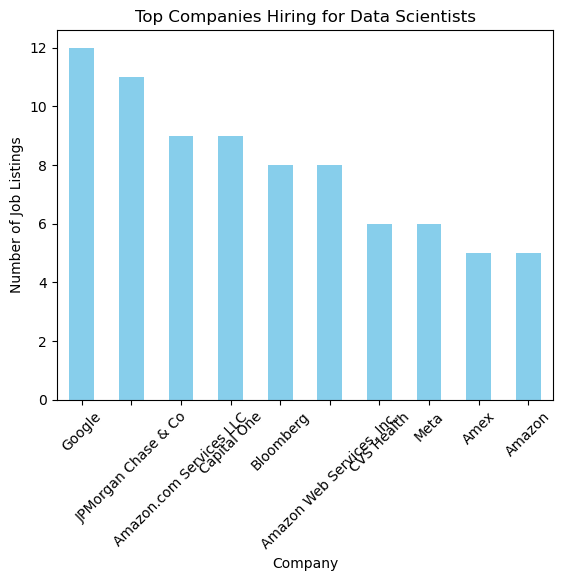

In [30]:
# Visual 1: Top Companies Hiring for Data Scientists
top_companies.plot(kind='bar', color='skyblue')
plt.title('Top Companies Hiring for Data Scientists')
plt.xlabel('Company')
plt.ylabel('Number of Job Listings')
plt.xticks(rotation=45)
plt.show()

#### Google leads with the highest number of job listings for data scientists, followed by JPMorgan Chase & Co and Amazon.com Services LLC. This indicates that tech giants and financial institutions are heavily investing in data science talent.


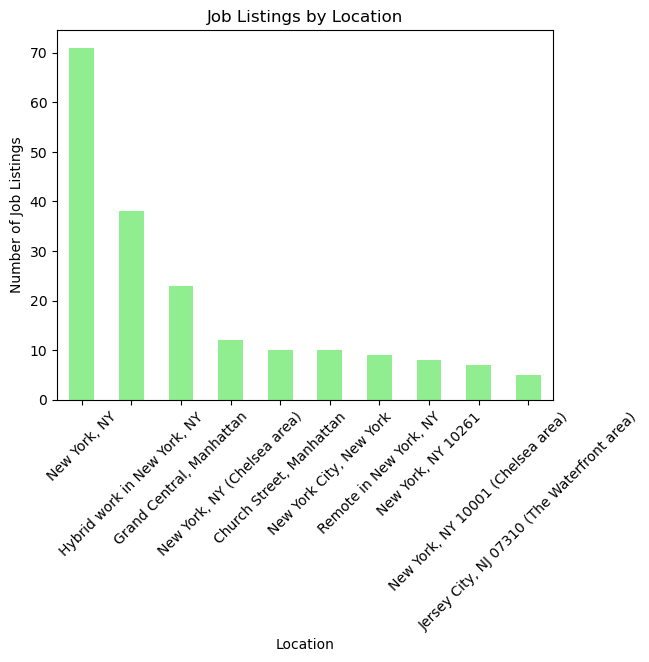

In [31]:
# Visual 2: Job Listings by Location
job_locations.plot(kind='bar', color='lightgreen')
plt.title('Job Listings by Location')
plt.xlabel('Location')
plt.ylabel('Number of Job Listings')
plt.xticks(rotation=45)
plt.show()

#### New York, NY, stands out as the primary location with the highest number of job listings, followed by hybrid work arrangements and Grand Central, Manhattan. This highlights that the majority of data scientist positions are concentrated in central New York City, with significant opportunities also available for hybrid working models.

### **5.2:** Reflection

##### Next steps:
1. Enhance data gathering by including more job portals.
2. Perform more detailed analysis on job descriptions to identify required skills and experience.